In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from functions import get_var_hist, create_R_v1, get_dyn_v2
from setup import setup_matplotlib
from scipy.linalg import expm

setup_matplotlib()

np.random.seed(42)

In [3]:
def simulate_traj_g(N_p, N_loop, N_t, ntau, s, dt, border, force):
    pos = np.empty((N_loop,N_p,N_t))
    vel = s*np.random.randn(N_loop,N_p,N_t)*1/np.sqrt(dt)

    pos[:,:,:ntau] = -border
    vel[:,:,:ntau] = 0

    for i in tqdm(range(ntau,N_t), leave=False):
        pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt
        vel[:,:,i] += force(pos[:,:,i-ntau], pos[:,:,i])
    return pos

def get_prop_abs_v2_g(x_s, force, D,dt,dx, N_border=None, side = 'lr'):
    # x(t-tau), x(t), res
    N_x = len(x_s)
    half_x_s = np.arange(x_s[0],x_s[-1]+dx/4,dx/2)
    mx_s = np.arange(x_s[0]-dx/2,x_s[-1]+dx/2+dx/4,dx)
    
    
    
    R_abs = np.zeros(( len(half_x_s),N_x, N_x))
    
    F = force(half_x_s[:,None], mx_s[None,:])
    
    lp = D / dx**2 * np.exp((F*dx/D)/2)  # r_i->i+1
    ln = D / dx**2 * np.exp(-(F*dx/D)/2)  # r_i+1->i

    R_abs[:,np.arange(0,N_x),np.arange(0,N_x)] = -(lp[:,1:]+ln[:,:-1]) # -(r_i->i+1 + r_i->i-1) ????
    R_abs[:,np.arange(0,N_x-1),np.arange(1,N_x)] = ln[:,1:-1]
    R_abs[:,np.arange(1,N_x),np.arange(0,N_x-1)] = lp[:,1:-1]
    
    prop_abs = expm(R_abs*dt, )
    if np.any(np.isnan(prop_abs)):
        print('CAREFUL: nan in prop, maybe because of to high values in potential')
    return prop_abs

In [4]:
k = 1
k2 = 0.5
s = 1
D = s**2/2
max_t = 6
ntau = 3
dx = 0.15 #0.3
eq_perc = 0.75


f = 4
N_p = 2_000
N_loop = 10



def force(x,x0,*args):
     return -k*x-k2*x0

ltaus = np.concatenate(([0.05], np.arange(0.2,2.2,0.1) ))
sim_vars = np.empty((len(ltaus),2))
sim_eq_time = np.empty((len(ltaus),2))

sim_hist_vars = np.empty((len(ltaus),2))
sim_hist_eq_time = np.empty((len(ltaus),2))

num_vars = np.empty((len(ltaus),2))
num_eq_time = np.empty((len(ltaus),2))

In [5]:
for i,ltau in enumerate(tqdm(ltaus)): 
    ldt = ltau/ntau if ltau > 0 else 0.01
    N_t = max(int(max_t/ldt), 30)
    
    ts = np.arange(0,N_t)*ldt
    sim_ts = np.arange(0,f*(N_t+ntau))*ldt/f-ltau
    
    
    pos = simulate_traj_g(N_p=N_p, N_loop=N_loop, N_t=(N_t+ntau)*f, ntau=ntau*f, s=s, dt=ldt/f,border=0, force=force)
    sim_var = np.var(pos, axis = 1)
    
    # adapt boundaries to varianz (from sim) -> 3 sigma
    sb = 3*np.sqrt(np.max(sim_var))
    sb = min(20*dx, np.round(sb/dx)*dx)
    
    x_s = np.arange(-sb,sb+1e-6,dx)
    bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
    N_x = len(x_s)
    print(N_x, N_x/ (2*np.sqrt(np.max(sim_var))/dx) )
    i_zero = np.argmin(x_s**2)

    
    sim_hists = np.swapaxes(np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1,2)
    sim_hist_var =  np.apply_along_axis(get_var_hist,-1, sim_hists, x_s=x_s)
    
    if ltau > 0:
        # v1
        # prop = get_prop_abs(x_s, force,D,ldt,dx)
        # R, _, end_states = create_R(N_x, ntau, prop)

        # v2
        prop = get_prop_abs_v2_g(x_s, force,D,ldt,dx)
        R, _, end_states = create_R_v1(N_x, ntau, prop)

        _, hists = get_dyn_v2(R, i_zero,N_t, N_x, ntau, end_states)
    else:
        print('tau = 0, Not integrated jet !!!!')
        continue
#     else:
#         R = get_non_delayed_prop(x_s, force,D,ldt,dx)
#         hists = get_non_delayed_dyn(R,i_zero,N_t, N_x)
    
    num_var = get_var_hist(hists, x_s)
    
    mean_sim_vars = np.mean(sim_var[:,-f*ntau*2:], axis = 1)
    sim_vars[i] = (np.mean(mean_sim_vars), np.std(mean_sim_vars)/np.sqrt(N_loop))
    
    mean_s_eq = sim_ts[np.argmin((eq_perc*mean_sim_vars[:,None]-sim_var)**2, axis = 1)]
    sim_eq_time[i] = (np.mean(mean_s_eq), np.std(mean_s_eq)/np.sqrt(N_loop))
    
    
    mean_sim_hist_var = np.mean(sim_hist_var[:,-f*ntau*2:], axis = 1)
    sim_hist_vars[i] = (np.mean(mean_sim_hist_var), np.std(mean_sim_hist_var)/np.sqrt(N_loop))
    
    mean_sh_eq = sim_ts[np.argmin((eq_perc*mean_sim_hist_var[:,None]-sim_hist_var)**2, axis = 1)]
    sim_hist_eq_time[i] = (np.mean(mean_sh_eq), np.std(mean_sh_eq)/np.sqrt(N_loop))
                  
    mean_num_var = np.mean(num_var[-ntau*2:])
    num_vars[i] =  (mean_num_var, np.max(num_var[-ntau*2:])-np.min(num_var[-ntau*2:]))
    num_eq_time[i] =  ts[np.argmin((eq_perc*mean_num_var-num_var)**2)]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/1440 [00:00<?, ?it/s]

25 3.0498628265887566


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

27 3.0239725199330865


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

29 3.117707422177047


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

31 3.1575295360740787


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

33 3.1659988747710464


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

33 3.074599894376203


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

35 3.1175091666962786


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

37 3.131083009791064


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

39 3.131124844724807


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

41 3.119868451309591


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

41 2.9596511836187878


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

41 2.790826949214228


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

41 2.5991134375126292


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

41 2.4930798015185323


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

41 2.3099103112302184


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

41 2.1770783975727706


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

41 2.0168225460366798


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

41 1.8421287038770837


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

41 1.7039339346471718


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

41 1.5637585280322563


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

41 1.3978588855231135


  0%|          | 0/29 [00:00<?, ?it/s]

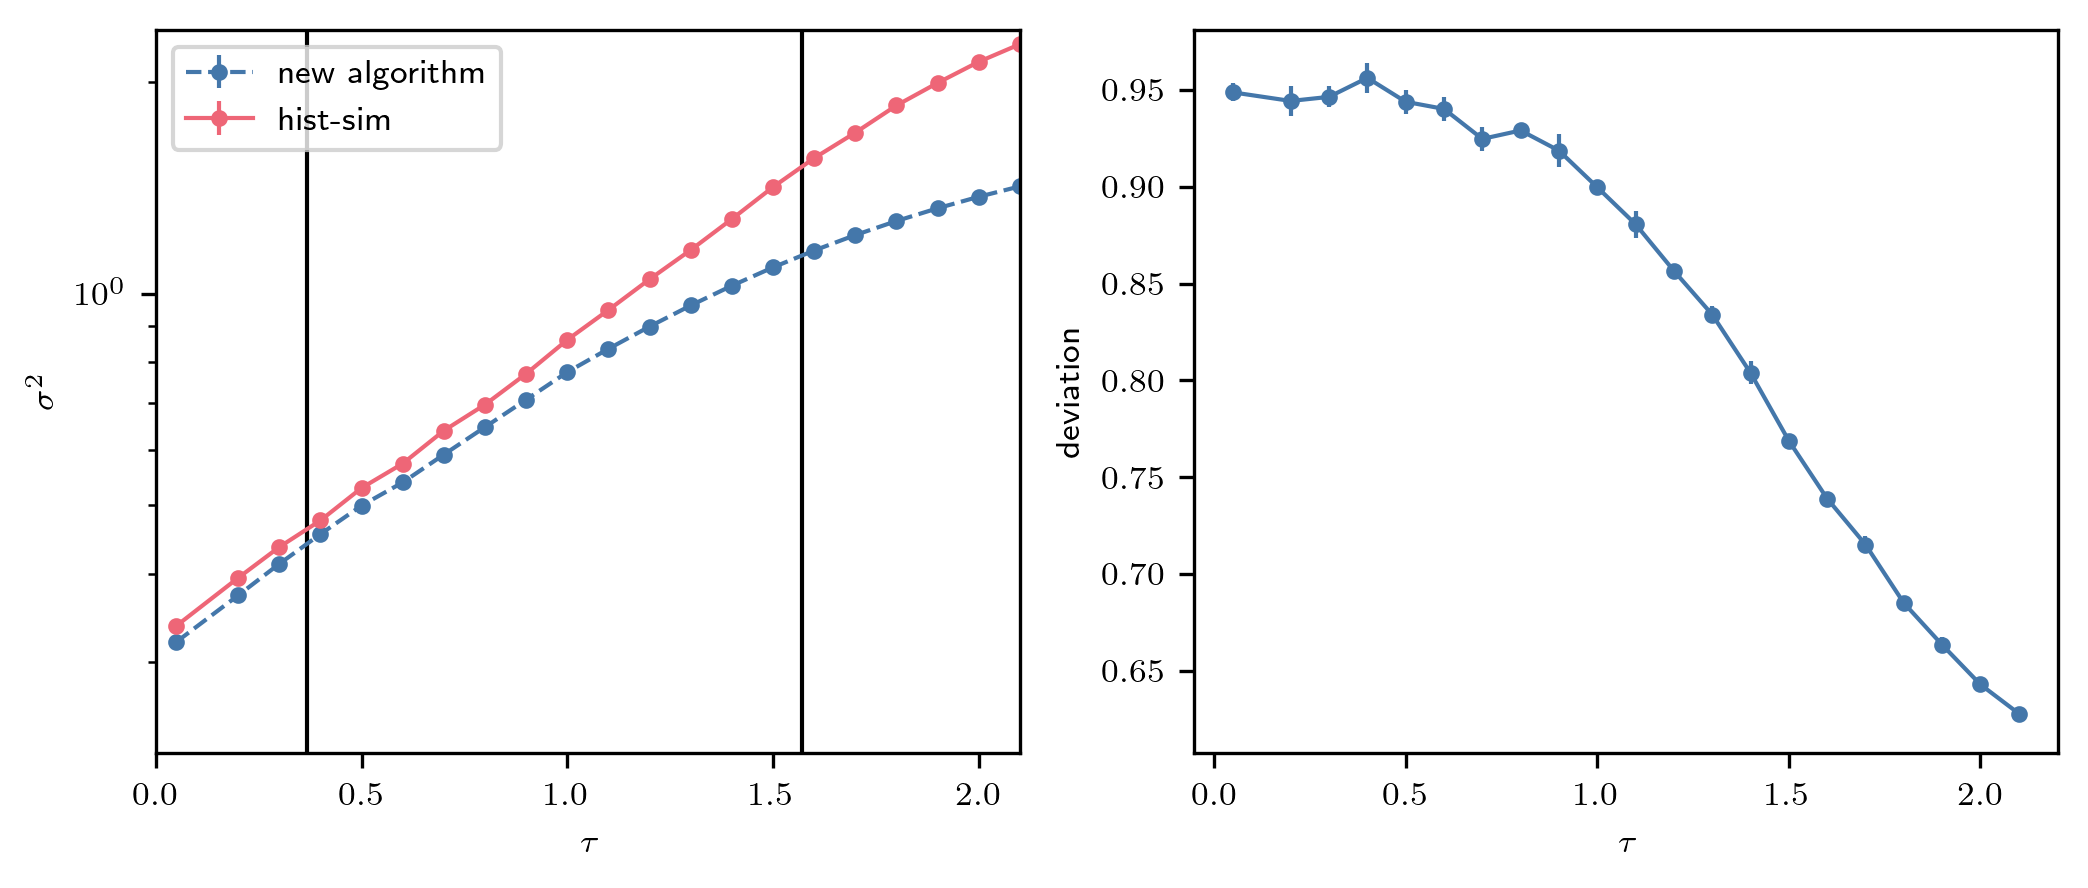

In [6]:
plt.figure(figsize=(7,3))
ax = plt.subplot(121)
#plt.plot(ltaus,sim_vars[:,0],'.-', label='sim')

plt.errorbar(ltaus,num_vars[:,0],num_vars[:,1],marker='.', ls='--', label='new algorithm')



#plt.plot(ltaus,short_time_approx_var ,'.-.',label='short time')
#plt.plot(ltaus[ltaus < np.pi/2/k],exact_sol[ltaus < np.pi/2/k] ,'.-.',label='exact')

plt.errorbar(ltaus,sim_hist_vars[:,0],sim_hist_vars[:,1],marker='.', label='hist-sim')
#plt.ylim(3e-1,10)
plt.ylim(*plt.ylim())
plt.xlim(0,2.1)
plt.vlines([1/np.e /k, np.pi/2/k],*plt.ylim(), color='black')
y = 4e-1
# plt.text(0.5*1/np.e /k,              y,'Regim I', ha='center', va='center')
# plt.text(0.5*(1/np.e /k+  np.pi/2/k),y,'Regim II',ha='center', va='center')
# plt.text(0.5*(np.pi/2/k + plt.xlim()[1]),            y,'Regim III',ha='center', va='center')

plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^2$')

#auflösungslimit
#plt.hlines((x_s[-1]/3)**2, *plt.xlim())

ax = plt.subplot(122)
plt.errorbar(ltaus, num_vars[:,0]/sim_hist_vars[:,0], 
             yerr = np.sqrt( ( num_vars[:,1]/sim_hist_vars[:,0])**2 + (num_vars[:,0]/sim_hist_vars[:,0]**2*sim_hist_vars[:,1])**2),
                            marker = '.')
#plt.plot(ltaus, num_vars[:,0]/sim_vars[:,0], '.-')
plt.xlabel(r'$\tau$')
plt.ylabel(r'deviation')


plt.tight_layout()
#plt.savefig('graphics/x2variance_v2_g.pdf')

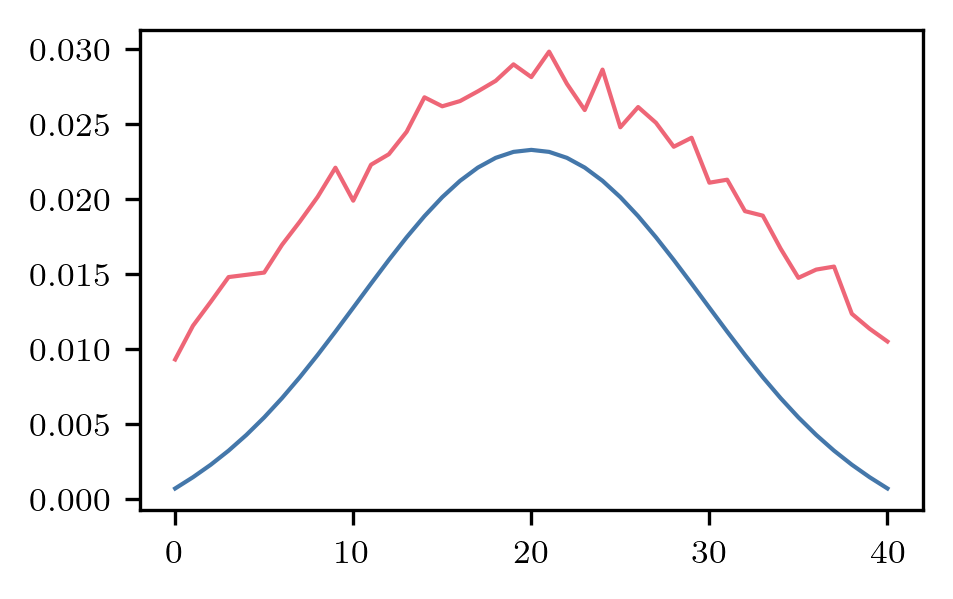

In [10]:
t_hists = sim_hists.sum(0) / sim_hists[:,0].sum()
plt.plot(hists[-1])
plt.plot(t_hists[-1])